In [1]:
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ocsmesh
import pyproj
from bluemath_tk.core.geo import buffer_area_for_polygon, mask_points_outside_polygon
from bluemath_tk.topo_bathy.mesh_utils import (
    adcirc2netcdf,
    clip_bathymetry,
    define_mesh_target_size,
    detect_circumcenter_too_close,
    plot_bathymetry,
    plot_bathymetry_interp,
    plot_boundaries,
    plot_mesh_edge,
    plot_mesh_vals,
    remove_islands,
    simply_polygon,
    read_lines
)
from bluemath_tk.topo_bathy.OCSMod import EuclideanMesh2D
from pyproj import CRS
from pyproj.enums import TransformDirection
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import transform

### Grid Parameters

In [2]:
Mean_Sea_Level = 2.5
figsize = (7, 7)

In [3]:
bathymetry_tif_raw_path = "/home/grupos/geocean/faugeree/BlueMath/toolkit/inputs/bati_santona.tif"

initial_raster_paths = [bathymetry_tif_raw_path]
output_bathy_clip_tif_path = "/home/grupos/geocean/faugeree/BlueMath/toolkit/outputs/bati_santona_clip.tif"

site = "Cantabria"

In [4]:
coords = [
[-3.52, 43.335],
[-3.52, 43.485],
[-3.38, 43.485],
[-3.38, 43.335],
[-3.52, 43.335],]

In [5]:
lon_center = np.mean(np.array(coords)[-1, 0])
lat_center = np.mean(np.array(coords)[-1, 1])

proj_str = (
    f"+proj=aeqd +lat_0={lat_center} +lon_0={lon_center} +units=m +datum=WGS84 + no_defs"
)
project = pyproj.Transformer.from_crs("EPSG:4326", proj_str, always_xy=True).transform

### Raster

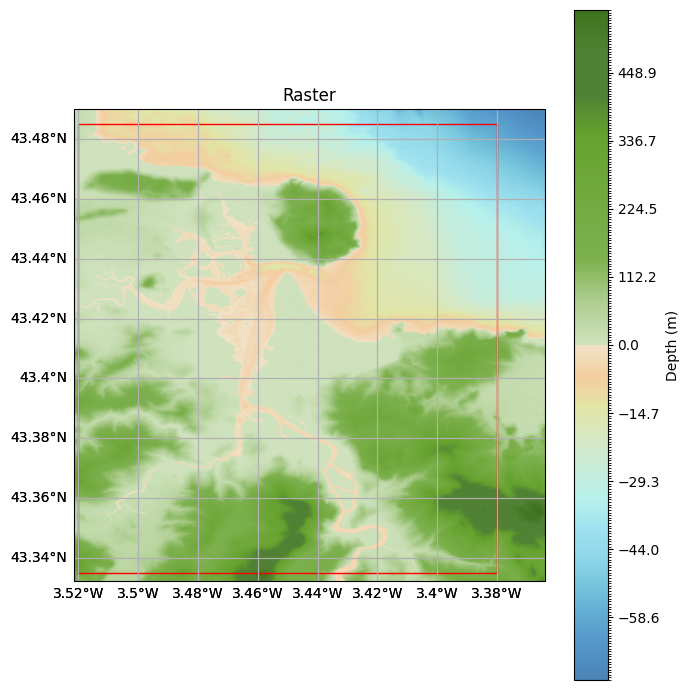

In [6]:
domain_crs = CRS.from_user_input("epsg:4326")
domain_polygon = Polygon(coords)


fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_bathymetry(initial_raster_paths, domain_polygon, ax)
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.tight_layout()
plt.show()

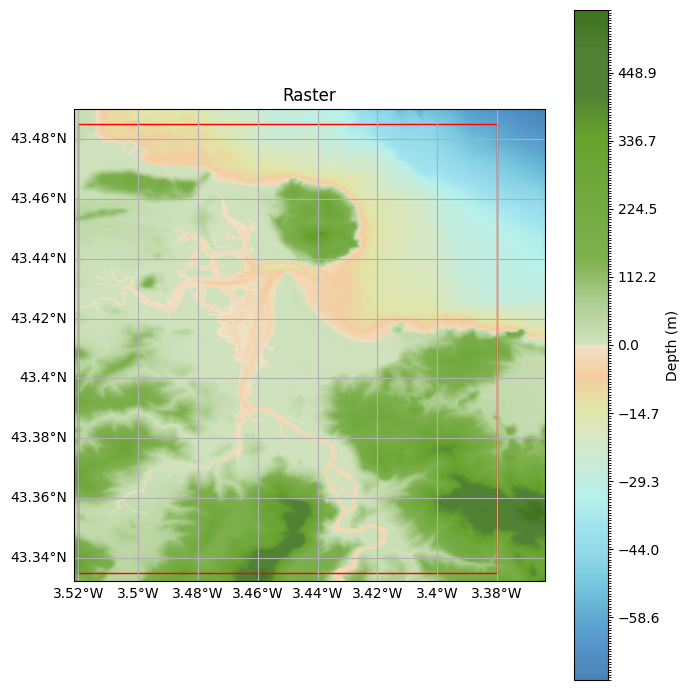

In [7]:
raster_resolution = clip_bathymetry(
    input_raster_paths=initial_raster_paths,
    output_path=output_bathy_clip_tif_path,
    domain=domain_polygon,
    margin=1,
)
clipped_raster_paths = [output_bathy_clip_tif_path]

x_center, y_center = project(lon_center, lat_center)
x_center_raster_resolution, y_center_raster_resolution = project(
    lon_center + raster_resolution / np.sqrt(2),
    lat_center + raster_resolution / np.sqrt(2),
)
raster_resolution_meters = np.mean(
    [
        abs(x_center - x_center_raster_resolution),
        abs(y_center - y_center_raster_resolution),
    ]
)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_bathymetry(clipped_raster_paths, domain_polygon, ax)
plt.tight_layout()
plt.show()

### Generacion polygon

In [8]:
# Define depth zones with mesh size and transition rate per range
# Format: (lower_bound, upper_bound): {'value': mesh_size, 'rate': expansion_rate}
expention_rate = None
depth_ranges = {
    (-200_000, -40): {"value": 1000, "rate": expention_rate}, # Maximum size
    (-40, -35): {"value": 600, "rate": expention_rate}, # Large size
    (-35, -30): {"value": 400, "rate": expention_rate}, # Large size
    (-30, -25): {"value": 200, "rate": expention_rate}, # Medium size
    (-25, -10): {"value": 100, "rate": expention_rate}, # Medium size
    (-10, -2.5): {"value": 50, "rate": expention_rate}, # Small size
    (-2.5, 25): {"value": 20, "rate": expention_rate}, # Minimum size
}

In [9]:
line_struct = read_lines("/home/grupos/geocean/faugeree/BlueMath/toolkit/inputs/poly_line.csv")
gdf = gpd.GeoDataFrame(geometry=[line_struct])

min_value = min(v["value"] for v in depth_ranges.values())
gdf = gdf.set_crs('EPSG:4326').to_crs(proj_str)
gdf_buffered_geo = gdf.buffer(min_value*2/3).to_crs(epsg=4326)[0]

polygon_detail_structure = gdf.buffer(min_value*5).to_crs(epsg=4326)[0]

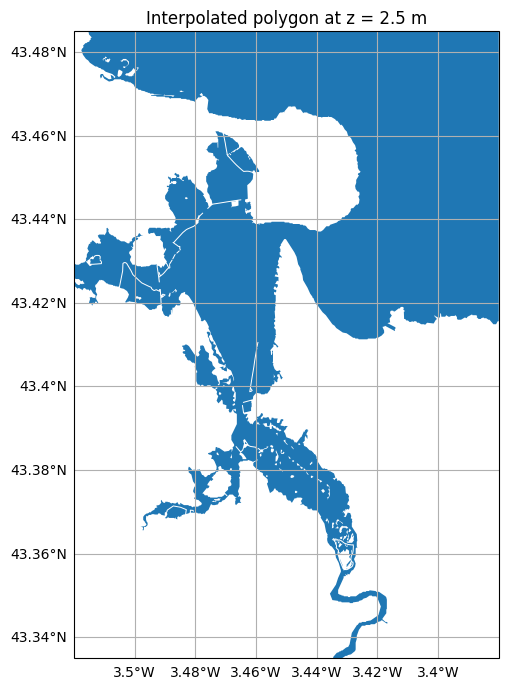

In [10]:
rasters = [ocsmesh.Raster(path) for path in clipped_raster_paths]
coastal_area = ocsmesh.Geom(rasters, zmax=Mean_Sea_Level).get_multipolygon()
intersected = coastal_area.intersection(domain_polygon)
if isinstance(intersected, MultiPolygon):
    raw_intersected_area = max(intersected.geoms, key=lambda p: p.area)
else:
    raw_intersected_area = intersected

simplyfied_polygon = simply_polygon(raw_intersected_area, 10, project)  # 10 meters simplification
intersected_area = remove_islands(simplyfied_polygon,1500, project) # island size 1500 m2 minimum
final_shape = intersected_area.difference(gdf_buffered_geo)

gdf = gpd.GeoSeries([final_shape], crs="EPSG:4326")
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
minx, miny, maxx, maxy = gdf.total_bounds
gdf.plot(ax=ax, transform=ccrs.PlateCarree())
ax.set_title(f"Interpolated polygon at z = {Mean_Sea_Level} m")
ax.set_extent([minx, maxx, miny, maxy], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.tight_layout()
plt.show()

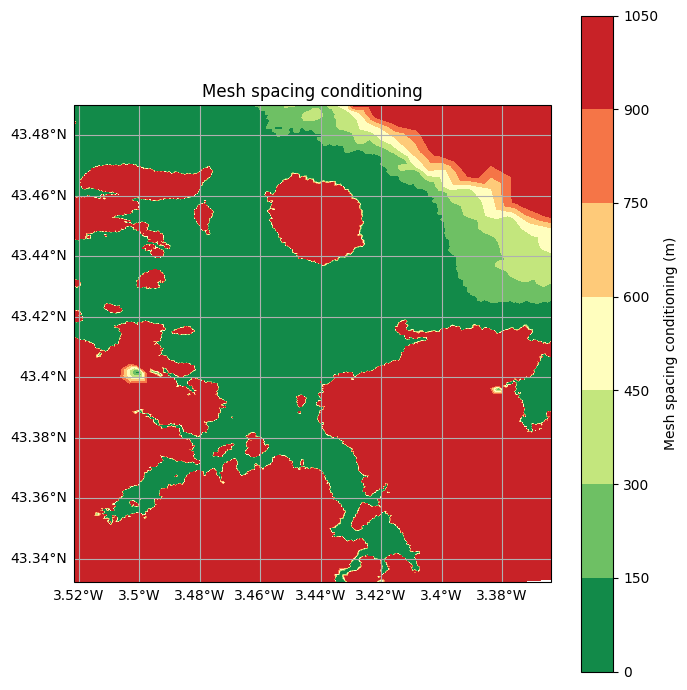

In [11]:
geometry = ocsmesh.Geom(
    [],
    base_shape=final_shape,
    base_shape_crs=domain_crs,
)
domain_multipolygon = geometry.get_multipolygon()

mesh_spacing = define_mesh_target_size(
    rasters, raster_resolution_meters, depth_ranges=depth_ranges, nprocs=25
)

mesh_spacing.add_region_constraint(value = min_value,shape = polygon_detail_structure,rate = None, crs = domain_crs, value_type =  'max')

mesh_spacing_field = mesh_spacing.msh_t()

CRS_OCS = mesh_spacing_field.crs
to_LL = pyproj.Transformer.from_crs(CRS_OCS, "EPSG:4326", always_xy=True).transform

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_mesh_vals(mesh_spacing_field, ax=ax, to_geo=to_LL, cmap="RdYlGn_r")
ax.set_title("Mesh spacing conditioning")
plt.tight_layout()

In [12]:
driver = ocsmesh.JigsawDriver(geom=geometry, hfun=mesh_spacing, initial_mesh=False)
mesh = driver.run(remesh_tiny_elements=True)
mesh.interpolate(rasters, method="linear")

In [13]:
copy_mesh = EuclideanMesh2D(mesh.msh_t)
data_mesh = copy_mesh.vert2
node_coords = np.array([item["coord"] for item in data_mesh])
elements = np.array(list(ocsmesh.utils.elements(mesh.msh_t).values()))

In [14]:
def to_geo(x, y):
    return to_LL(x, y, direction=TransformDirection.INVERSE)


intersected_area_UTM = transform(to_geo, intersected_area)                               # clean island too
#intersected_area_UTM = Polygon(transform(to_geo, intersected_area).exterior.coords)     # only clean boondary

intersected_area_UTM_extended = buffer_area_for_polygon(intersected_area_UTM, 0.0001)

mask_generation_outside = mask_points_outside_polygon(
    elements, node_coords, intersected_area_UTM_extended
)
print(f"Number of elements outside the polygon: {mask_generation_outside.sum()}")

mask_circumcenter = detect_circumcenter_too_close(
    node_coords[:, 0], node_coords[:, 1], elements
)
print(f"Number of elements with circumcenter too close: {mask_circumcenter.sum()}")

complete_mask = mask_generation_outside | mask_circumcenter

Number of elements outside the polygon: 11609
Number of elements with circumcenter too close: 207


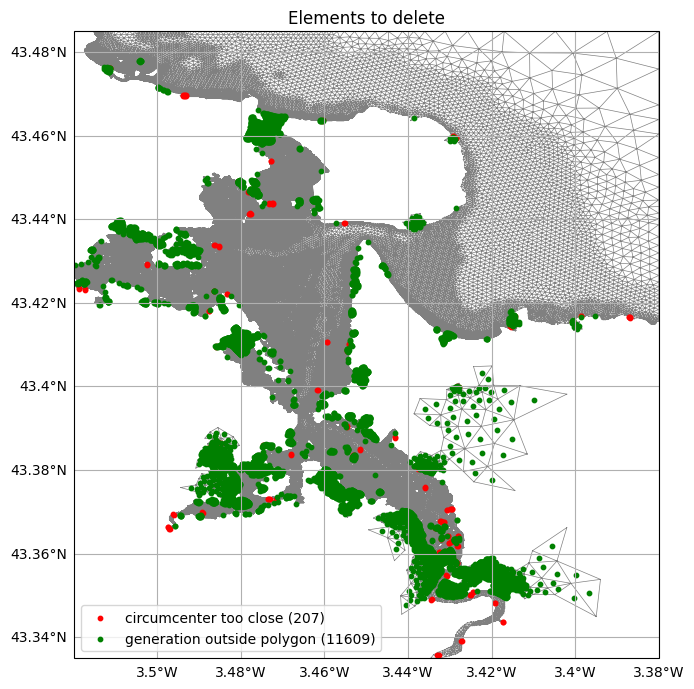

In [15]:
bad_elements_generation = np.mean(
    node_coords[elements[mask_generation_outside]], axis=1
)
bad_elements_circumcenter = np.mean(node_coords[elements[mask_circumcenter]], axis=1)

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=figsize)
plot_mesh_edge(copy_mesh.msh_t, to_geo=to_LL, ax=ax, color="gray", lw=0.5)


ax.scatter(
    *to_LL(
        bad_elements_circumcenter[:, 0].flatten(),
        bad_elements_circumcenter[:, 1].flatten(),
    ),
    color="red",
    s=10,
    label=f"circumcenter too close ({mask_circumcenter.sum()})",
)
ax.scatter(
    *to_LL(
        bad_elements_generation[:, 0].flatten(), bad_elements_generation[:, 1].flatten()
    ),
    color="green",
    s=10,
    label=f"generation outside polygon ({mask_generation_outside.sum()})",
)

ax.set_title("Elements to delete")
ax.legend()
plt.tight_layout()

In [16]:
cleaned_mesh = ocsmesh.utils.clip_elements_by_index(
    copy_mesh, tria=complete_mask, quad=None
)
ocsmesh.utils.finalize_mesh(cleaned_mesh)

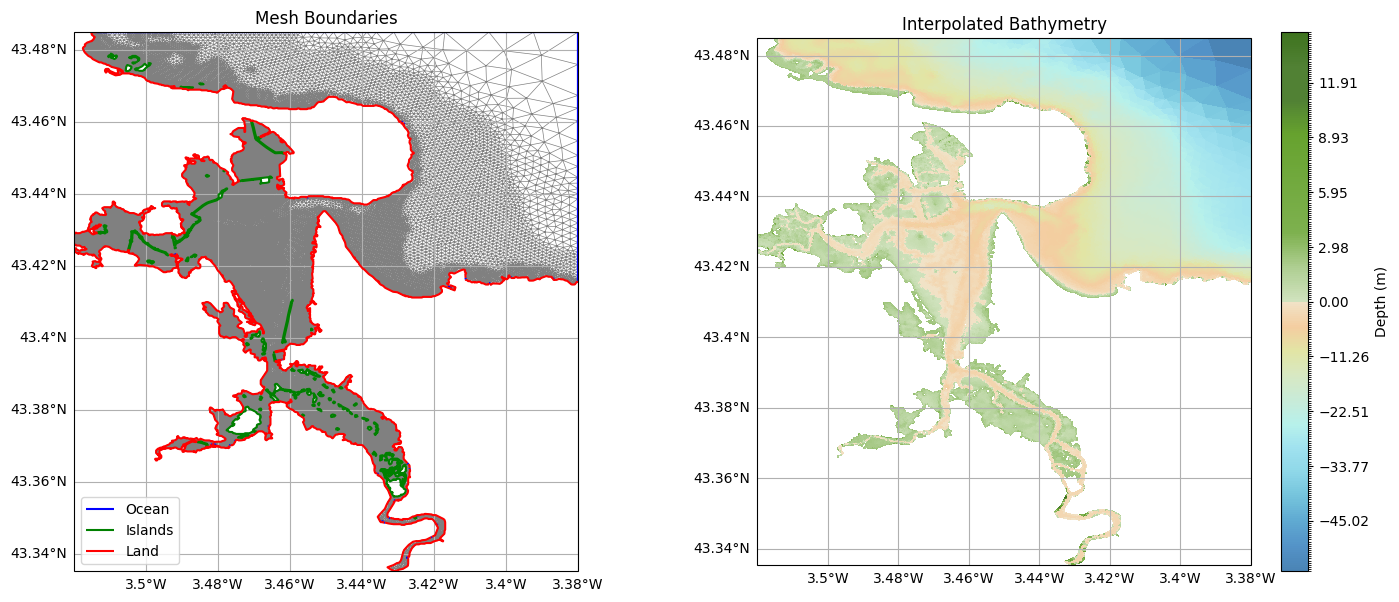

In [17]:
cleaned_mesh.interpolate(rasters, method="linear")
cleaned_mesh.boundaries.auto_generate(-1)

fig, (ax1, ax2) = plt.subplots(
    1,
    2,
    figsize=(figsize[0] * 2.5, figsize[1]),
    subplot_kw={"projection": ccrs.PlateCarree()},
)

plot_boundaries(cleaned_mesh, to_geo=to_LL, ax=ax1)
plot_bathymetry_interp(cleaned_mesh, to_LL, ax2)

## Save output files

In [18]:
from bluemath_tk.topo_bathy.mesh_utils import adcirc2netcdf

path_grd = f"/home/grupos/geocean/faugeree/BlueMath/toolkit/outputs/{site}_mesh_adcirc.grd"
path_nc = f"/home/grupos/geocean/faugeree/BlueMath/toolkit/outputs/{site}_mesh_net.nc"
cleaned_mesh.write(path_grd, format="grd", overwrite=True)
adcirc2netcdf(path_grd, path_nc)